In [1]:
import torch
import pickle as pkl
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.data import Batch
import torch.nn as nn
from sklearn.manifold import TSNE
from rdkit import Chem
%matplotlib inline
import matplotlib.pyplot as plt
from GNN_mol import GNN
from Dataset import XASDataset
from utils import plot_spectra,plot_learning_curve

/p/software/juwelsbooster/stages/2023/software/tqdm/4.64.0-GCCcore-11.3.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define routines to be used

In [2]:
def train(epoch):
    model.train()
    loss_all = 0
    node_list = []
    select_list = []
    tot_list = []
    smiles_list = []
    # batch_size = 128
    for batch in train_loader:

        # print(batch.idx,batch.smiles)
        batch = batch.to(device)
        # x, edge_index,index = batch.x,batch.edge_index,batch.index

        # print(batch.idx,batch.atom_index)
        # Add batch dimension to index
        # batch_index = index.unsqueeze(1)

        optimizer.zero_grad()

        pred = model(batch)
        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)
        # pred = torch.clamp(pred, min=0.0)
        # print(batch.y.shape)
        # new_pred=pred.view(batch.y[:,0:99].shape)

        # pred = ss[0]
        # emb = ss[1]
        alpha = 10

        # loss = nn.MSELoss()(pred.view(-1, 1).double(),
        #                batch.y[:,:100].view(-1, 1).double())

        loss = nn.MSELoss()(pred.double(), batch.y.double())
        # + alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))

        # p_loss = nn.SmoothL1Loss()(new_pred.double(),
        #                batch.y.double())

        # loss = nn.SmoothL1Loss()(pred.view(-1, 1).double(),
        #                batch.y.view(-1, 1).double())
        # print(loss)
        # print(pred.view(-1, 1).double(), batch.y.view(-1, 1).double())
        # pred_list.append(pred.view(-1, 1).double())
        # y_list.append(batch.y.view(-1, 1).double())

        loss.backward()
        # print(batch.num_graphs)
        loss_all += loss.item() * batch.num_graphs
        optimizer.step()

    #        if epoch == 999 :
    #            node_list.append(node)
    #            select_list.append(select)
    #            smiles_list.append(batch.smiles)
    #            tot_list.append(tot)
    #    a = 0
    #    b = 0
    #    c = 0
    #    d = 0
    #    if epoch == 999:
    #        a = node_list
    #        b = select_list
    #        c = smiles_list
    #        d = tot_list

    # print(len(train_loader.dataset))
    # emb_list.append(emb)
    return loss_all / len(train_loader.dataset)

In [3]:
def test(loader):
    model.eval()
    loss_all = 0

    for batch in loader:
        batch = batch.to(device)
        # x, edge_index, index = batch.x, batch.edge_index, batch.index

        # Add batch dimension to index
        # batch_index = index.unsqueeze(1)
        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)

        with torch.no_grad():
            pred = model(batch)

        # print(pred)
        #     alpha=10
        # loss = nn.MSELoss()(pred.view(-1, 1).double(),
        #                  batch.y.view(-1, 1).double())

        loss = nn.MSELoss()(pred.double(), batch.y.double())
        #    +alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))
        # loss = nn.SmoothL1Loss()(pred.view(-1, 1).double(),
        #                 batch.y.view(-1, 1).double())
        loss_all += loss.item() * batch.num_graphs

    return loss_all / len(loader.dataset)

In [18]:
def pred_spec(model,index,test_dataset):
    # Set the model to evaluation mode
    model.eval()

    # Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])

    # Pass the graph through the model
    with torch.no_grad():
        pred = model(batch)

    # Access the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.y.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum,true_spectrum

#### Load the data

In [4]:
# Path raw directory containing the data
path = "/p/project/hai_ml_xas/Sam_ML/GO_molecule_GNN"
# Load and create the dataset
dataset = XASDataset(path)

In [5]:
print("Total number of data points in the dataset:", len(dataset))

Total number of data points in the dataset: 319


#### Split into test, validation and test datasets

In [6]:
train_dataset = dataset[0:252]
val_dataset = dataset[252:280]
test_dataset = dataset[280:]

In [7]:
train_dataset[0]

Data(x=[30, 16], edge_index=[2, 76], y=[200], edge_attrs=[76, 7], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[cH:11][cH:14][c:15]6[c:13]4[c:17]4[c:19]([cH:18][cH:16]6)[cH:20][c:22]([OH:25])[c:23]([c:21]14)[CH2:24][CH:1]1[C:2]2([CH:3]=[CH:5][C:6]32[CH:7]([CH:9]5[C:12](=[O:26])[OH:27])[O:29]2)[O:28]1')

In [8]:
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)

#### Set neural network properties

In [9]:
num_tasks = 200
num_layers = 5
emb_dim = dataset.num_features
print(emb_dim)
in_channels = [int(emb_dim), 100, 150, 175, 200]
print(in_channels)
out_channels = [100, 150, 175, 200, 200]
gnn_type = "gcn"
heads = int(1)
drop_ratio = 0.8
graph_pooling = "mean"

16
[16, 100, 150, 175, 200]


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)

In [11]:
model

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(16, 100)
      (1): GCNConv(100, 150)
      (2): GCNConv(150, 175)
      (3): GCNConv(175, 200)
      (4): GCNConv(200, 200)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(175, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=200, out_features=200, bias=True)
)

In [12]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001
)
# scheduler =torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,300,500], gamma=0.5)

#### Run neural network training

In [13]:
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(0, 300):

    loss = train(epoch)

    val_error = test(val_loader)
    scheduler.step(val_error)
    # scheduler.step(epoch)
    train_losses.append(loss)
    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]["lr"]

    if best_val_error is None or val_error <= best_val_error:

        best_val_error = val_error
    if epoch % 25 == 0:
        print(
            f"Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}"
        )

Epoch: 000, LR: 0.010000, TrainLoss: 0.2154697, ValLoss:0.074877, Best_ValLoss:0.074877
Epoch: 025, LR: 0.010000, TrainLoss: 0.0143497, ValLoss:0.011164, Best_ValLoss:0.011164
Epoch: 050, LR: 0.010000, TrainLoss: 0.0106245, ValLoss:0.009768, Best_ValLoss:0.009768
Epoch: 075, LR: 0.010000, TrainLoss: 0.0100096, ValLoss:0.010370, Best_ValLoss:0.009415
Epoch: 100, LR: 0.010000, TrainLoss: 0.0097403, ValLoss:0.010102, Best_ValLoss:0.009415
Epoch: 125, LR: 0.010000, TrainLoss: 0.0094487, ValLoss:0.010374, Best_ValLoss:0.009415
Epoch: 150, LR: 0.010000, TrainLoss: 0.0090643, ValLoss:0.010098, Best_ValLoss:0.009233
Epoch: 175, LR: 0.010000, TrainLoss: 0.0091160, ValLoss:0.010243, Best_ValLoss:0.009233
Epoch: 200, LR: 0.010000, TrainLoss: 0.0088928, ValLoss:0.009657, Best_ValLoss:0.009233
Epoch: 225, LR: 0.010000, TrainLoss: 0.0090703, ValLoss:0.010205, Best_ValLoss:0.009233
Epoch: 250, LR: 0.005000, TrainLoss: 0.0088105, ValLoss:0.009896, Best_ValLoss:0.009233
Epoch: 275, LR: 0.005000, TrainL

In [14]:
torch.save(model.state_dict(), "ML_models/model_gnn_15.pt")

#### View loss

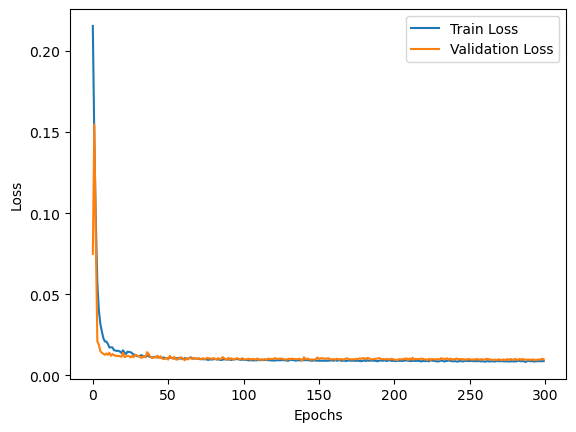

In [15]:
num_e = 300

plot_learning_curve(num_e, train_losses, val_losses)

#### Load model and predict spectra

In [16]:
# Load the saved model
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
mode = model.to(device)
model.load_state_dict(torch.load("ML_models/model_gnn_15.pt"))

<All keys matched successfully>

#### Plot predicted spectra

In [19]:
# Create empty dictionary to contain spectra
predict = {}
true = {}

# Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = pred_spec(model, index, test_dataset)

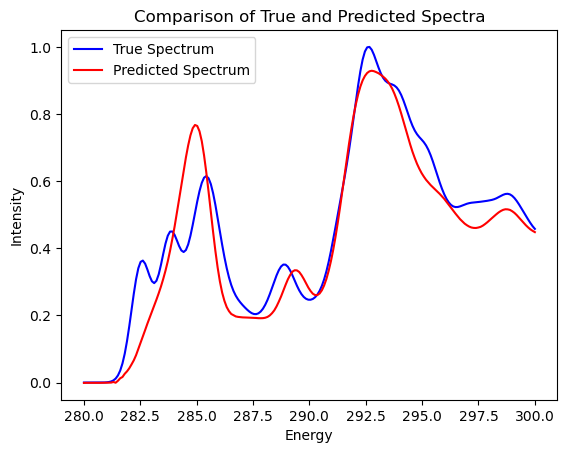

In [20]:
save_var = 1

plot_spectra(predict[20], true[20], save_var)

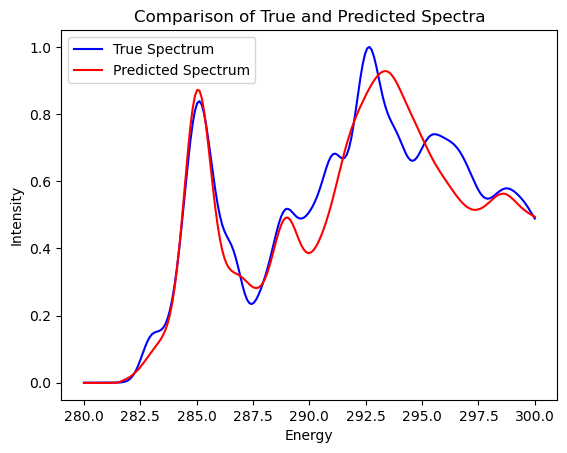

In [21]:
plot_spectra(predict[5], true[5], save_var)

In [ ]:
model_dict = [predict, true]

#### Save spectra

In [18]:
with open("/p/project/hai_ml_xas/Sam_ML/GO_molecule_GNN/spectra_results/spectra_ml_15.pkl", "wb") as file:
    pkl.dump(model_dict, file)

In [ ]:
t0 = train_dataset[30]

In [ ]:
t0.x

In [ ]:
model.eval()
for batch in train_loader:
    batch = batch.to(device)
    embeddings = model.forward(batch)

In [ ]:
embeddings[1][0]

In [ ]:
embeddings[1][1]